<a href="https://colab.research.google.com/github/dongxiangtranslationproject/dongxiangtranslationproject.github.io/blob/main/reverse_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dongxiang-Chinese Dictionary (After human verification and English translation)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
df2 = pd.read_csv('/content/drive/MyDrive/back_translation_template.csv')

In [ ]:
target_pos = ['Verb', 'Noun', 'Adjective', 'Adverb', 'Pronoun', 'Numeral']
df_core = df2[df2['POS'].isin(target_pos)].reset_index(drop=True)

In [ ]:
df2.isna().sum()

,0
Unnamed: 0,0
Dongxiang,0
POS,0
ORIGIN,0
Chinese,0
English,0
SyntaxRole,0


Due to the scarcity of Dongxiang sentences, we adopt a reverse translation strategy to manually generate more sentences to expand our bilingual corpus.<br>

While the English translations of individual words are currently produced by **ChatGPT**, it may be still preferable to rely on the English translations provided in the original Dongxiang–Chinese dictionary to find proper Dongxiang words. Because unlike Chinese, English and Dongxiang words are clearly separated, which creates favorable conditions for establishing a one-to-one mapping relationship in the word embedding space. <br>

To be more specific, we adopt a rule-based sentence generation strategy. First, we select core lexical categories,**verbs, nouns, adjectives, adverbs, pronouns, and numerals**. These parts of speech are then systematically combined according to canonical syntactic roles such as subject (S), verb (V), object (O) to generate meaningful sentence templates.




In [ ]:
df2['Chinese'] = df2['Chinese'].astype(str).str.split('，')
df2 = df2.explode('Chinese').reset_index(drop=True)

display(df2)

,Unnamed: 0,Dongxiang,POS,ORIGIN,Chinese,English,SyntaxRole
0,0,a,Verb,Dongxiang,买,Buy,V
1,1,a,Verb,Dongxiang,买,Buy,O
2,2,a,Verb,Dongxiang,取,Fetch,V
3,3,a,Verb,Dongxiang,取,Fetch,O
4,4,a,Verb,Dongxiang,拿,Take,V
...,...,...,...,...,...,...,...
22928,23686,zurulie,Verb,Dongxiang,小声嘟囔或哭闹,Murmur,V
22929,23687,zuzhila,Verb,Chinese,整人,Prank,V
22930,23688,zuzhila,Verb,Chinese,整人,Prank,O
22931,23689,zuzu,Verb,Chinese,小卒,Pawn,V


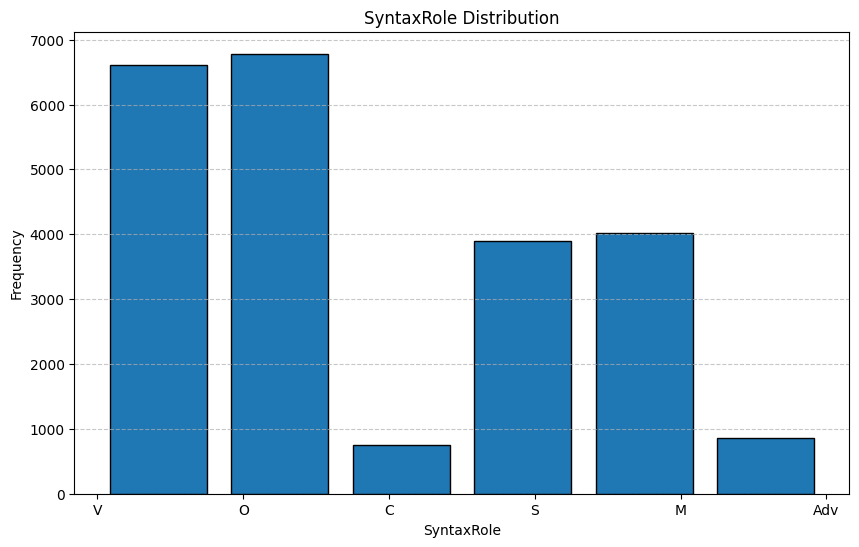

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

counts = df2['SyntaxRole'].value_counts()
plt.figure(figsize=(10, 6))
plt.hist(df2['SyntaxRole'], bins=len(counts), rwidth=0.8, edgecolor='black')

plt.title('SyntaxRole Distribution')
plt.xlabel('SyntaxRole')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


We have decided to use the following four basic sentence structures to construct translation based on the Dongxiang Chinese Dictionary

| Dongxiang Sentence Pattern | Corresponding English Syntax | Standard English Example              | English Example in Dongxiang Word Order      |
|----------------------------|-------------------------------|----------------------------------------|------------------------------------------------|
| SOV                        | SVO                            | He ate an apple.                       | He an apple ate.                               |
| SVC                        | SVC                            | He is a teacher.                       | He a teacher is.                               |
| SOV-C                      | SVO + Object Complement (OC)   | We elected him president.             | We him elected president.                      |
| SAOV                       | SVO + Adverbial                | He is eating an apple in Beijing.     | He in Beijing an apple eating is.             |


# SVO

In [ ]:
from tqdm.notebook import tqdm
from openai import OpenAI
import pandas as pd
import os

client = OpenAI(api_key="")
records = []
word_list = df2["English"].unique()

for word in tqdm(word_list, desc="Building SVO/SOV examples", unit="word"):
    prompt = f"""
You are an English teacher and syntax expert.
The target word is: "{word}".

Task:
1. Check if this word can naturally be used as a **transitive verb** in an English **SVO sentence**
   (Subject + Verb + Object).
   - If YES → create exactly FIVE simple sentences in SVO with this word.
   - If NO → return nothing (empty output).

2. For each valid SVO sentence, also give the corresponding **SOV version** (Dongxiang-style),
   where the Object comes before the Verb:
   Example:
   SVO: They read the book.
   SOV: They the book read.

3. Strict output format (one line per sentence):
[word, SVO sentence, SOV sentence]

Rules:
- Use only transitive verbs (must have subject + verb + object).
- Do NOT use linking verbs (be, become, seem, look, feel, etc.).
- Do NOT output explanations or extra text.
"""

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are a precise and structured assistant."},
                {"role": "user", "content": prompt}
            ],
            temperature=0
        )
        result = response.choices[0].message.content.strip()
    except Exception as e:
        from tqdm import tqdm as _tqdm
        _tqdm.write(f"Error for '{word}': {e}")
        continue

    if result:
        lines = [ln for ln in result.splitlines() if ln.strip()]
        for line in lines:
            inner = line.strip().strip("[]")
            parts = [p.strip() for p in inner.split(",", maxsplit=2)]
            if len(parts) == 3:
                word_out, svo_sentence, sov_sentence = parts
                records.append([word_out, svo_sentence, sov_sentence])

df = pd.DataFrame(records, columns=["Word", "SVO", "SOV"])
df.to_csv("SVO.csv")


Building SVO/SOV examples:   0%|          | 0/7557 [00:00<?, ?word/s]

In [ ]:
display(df)

,Word,SVO,SOV
0,Buy,She buys groceries,She groceries buys
1,Buy,He buys a car,He a car buys
2,Buy,They buy a house,They a house buy
3,Buy,We buy tickets,We tickets buy
4,Buy,I buy a gift,I a gift buy
...,...,...,...
11776,pawn,He pawned the watch.,He the watch pawned.
11777,pawn,She pawned her necklace.,She her necklace pawned.
11778,pawn,They pawned the guitar.,They the guitar pawned.
11779,pawn,John pawned his ring.,John his ring pawned.


# SVC

In [ ]:
from tqdm.notebook import tqdm
from openai import OpenAI
import pandas as pd
import os

records = []
word_list = df2["English"].unique()

for word in tqdm(word_list, desc="Building SVC examples", unit="word"):
    prompt = f"""
You are an English teacher and syntax expert.
The target word is: "{word}".

Task:
1. Judge whether this word can naturally be used as a **copular/linking verb**
   (e.g., be, become, seem, appear, look, feel, remain, grow, turn, sound, prove, stay)
   in an **SVC sentence**: Subject + Verb (copula) + Complement.

2. If YES:
   - Create exactly FIVE simple **SVC sentences** using this word.
   - The complement (C) must describe the subject (typically adjective or noun phrase).
   - Keep sentences short and natural.

3. If NO → return nothing at all (empty output).

Output format (strict, one line per sentence):
[word, SVC sentence]

Rules:
- Do NOT produce SVO sentences (with objects).
- Do NOT add explanations or extra text.
"""

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are a precise and structured assistant."},
                {"role": "user", "content": prompt}
            ],
            temperature=0
        )
        result = response.choices[0].message.content.strip()
    except Exception as e:
        from tqdm import tqdm as _tqdm
        _tqdm.write(f"Error for '{word}': {e}")
        continue

    if result:
        lines = [ln for ln in result.splitlines() if ln.strip()]
        for line in lines:
            inner = line.strip().strip("[]")
            parts = [p.strip() for p in inner.split(",", maxsplit=1)]
            if len(parts) == 2:
                word_out, svc_sentence = parts
                records.append([word_out, svc_sentence])

df = pd.DataFrame(records, columns=["Word", "SVC"])
df.to_csv("SVC.csv")

Building SVC examples:   0%|          | 0/7557 [00:00<?, ?word/s]

In [ ]:
df

,Word,SVC
0,buy,The price is a bargain to buy.
1,buy,This option seems the best to buy.
2,buy,The choice is hard to buy.
3,buy,The deal feels too good to buy.
4,buy,The offer appears tempting to buy.


# SVOA


In [ ]:
from tqdm.notebook import tqdm
from openai import OpenAI
import pandas as pd
import os

records = []
word_list = df2["English"].unique()

for word in tqdm(word_list, desc="Building SVOA/SAOV examples", unit="word"):
    prompt = f"""
You are an English teacher and syntax expert.
The target word is: "{word}".

1. Decide whether this word can be used as a **transitive verb** in an English SVOA sentence
   (Subject + Verb + Object + Adjunct [time, place, manner, frequency, etc.]).
   - If YES → create exactly FIVE simple SVOA sentences using this word.
   - If NO → return nothing (empty output).

2. For each valid SVOA sentence, also give the corresponding **SAOV version** (Dongxiang-style),
   where the order is:
   Subject + Adjunct + Object + Verb.
   Example:
   SVOA: They read the book in the library.
   SAOV: They in the library the book read.

3. Strict format (one line per sentence):
[word, SVOA sentence, SAOV sentence]

Rules:
- Always include a clear Adjunct (time / place / manner / frequency).
- Do NOT use linking verbs (be, become, seem, etc.).
- Use only simple sentences, no commas, no explanations.
"""


    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are a precise and structured assistant."},
                {"role": "user", "content": prompt}
            ],
            temperature=0
        )
        result = response.choices[0].message.content.strip()
    except Exception as e:
        from tqdm import tqdm as _tqdm
        _tqdm.write(f"Error for '{word}': {e}")
        continue

    if result:
        lines = [ln for ln in result.splitlines() if ln.strip()]
        for line in lines:
            inner = line.strip().strip("[]")
            parts = [p.strip() for p in inner.split(",", maxsplit=2)]
            if len(parts) == 3:
                word_out, svo_sentence, sov_sentence = parts
                records.append([word_out, svo_sentence, sov_sentence])

df = pd.DataFrame(records, columns=["Word", "SVOA", "SAOV"])
df.to_csv("SAOV.csv")

Building SVOA/SAOV examples:   0%|          | 0/7557 [00:00<?, ?word/s]

In [ ]:
df

,Word,SVOA,SAOV
0,buy,I will buy a new car tomorrow.,I tomorrow a new car buy.
1,buy,She buys groceries every Saturday.,She every Saturday groceries buys.
2,buy,They bought a gift for her at the store.,They at the store a gift for her bought.
3,buy,He is going to buy a book this afternoon.,He this afternoon a book is going to buy.
4,buy,We often buy fresh vegetables at the market.,We at the market fresh vegetables often buy.


# SVOOC

In [ ]:
from tqdm.notebook import tqdm
from openai import OpenAI
import pandas as pd
import os

records = []
word_list = df2["English"].unique()

for word in tqdm(word_list, desc="Building SVOOC/SOVC examples", unit="word"):
    prompt = f"""
You are an English teacher and syntax expert.
The target word is: "{word}".

1. Decide whether this word can naturally be used as a **transitive verb that takes an Object Complement (OC)** in English.
   - If YES → create exactly FIVE simple **SVO+OC sentences** (Subject + Verb + Object + Object Complement).
   - If NO → return nothing (empty output).

2. For each valid SVO+OC sentence, also give the corresponding **SOVC version** (Dongxiang-style),
   where the order is:
   Subject + Object + Complement + Verb.
   Example:
   - SVO+OC: They made him angry.
   - SOVC:   They him angry made.

3. Strict format (one line per sentence):
[word, SVO+OC sentence, SOVC sentence]

Rules:
- Only use verbs that can naturally take an object complement (make, elect, call, paint, keep, leave, consider, etc.).
- Do NOT use linking verbs (be, become, seem, etc.).
- Do NOT add explanations or extra text.
- Use simple sentences, no commas.
"""


    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are a precise and structured assistant."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.3
        )
        result = response.choices[0].message.content.strip()
    except Exception as e:
        from tqdm import tqdm as _tqdm
        _tqdm.write(f"Error for '{word}': {e}")
        continue

    if result:
        lines = [ln for ln in result.splitlines() if ln.strip()]
        for line in lines:
            inner = line.strip().strip("[]")
            parts = [p.strip() for p in inner.split(",", maxsplit=2)]
            if len(parts) == 3:
                word_out, svo_sentence, sov_sentence = parts
                records.append([word_out, svo_sentence, sov_sentence])

df = pd.DataFrame(records, columns=["Word", "SVOOC", "SOVC"])
df.to_csv("SVOOC.csv")

Building SVOOC/SOVC examples:   0%|          | 0/7557 [00:00<?, ?word/s]

In [ ]:
df

,Word,SVOOC,SOVC
0,take,They took her prisoner,They her prisoner took
1,take,The team took him captain,The team him captain took
2,take,She took the dog home,She the dog home took
3,take,We took the room clean,We the room clean took
4,take,He took the book interesting,He the book interesting took
...,...,...,...
2026,Brownify,She brownified the walls brown,She the walls brown brownified
2027,Brownify,They brownified the cake chocolatey,They the cake chocolatey brownified
2028,Brownify,We brownified the room darker,We the room darker brownified
2029,Brownify,He brownified the shoes tan,He the shoes tan brownified


# Check sentences

We rely on chatgpt again to ensure that each sentences are legal.

In [ ]:
import pandas as pd

def load_and_standardize(path, encoding="gbk"):
    df = pd.read_csv(path, encoding=encoding)
    df = df.iloc[:, 2:4]
    df.columns = ["English", "Dongxiang"]
    return df

df3 = load_and_standardize("/content/drive/MyDrive/SAOV.csv")
df4 = load_and_standardize("/content/drive/MyDrive/SVC.csv")
df5 = load_and_standardize("/content/drive/MyDrive/SVOOC.csv")
df6 = load_and_standardize("/content/drive/MyDrive/SVO.csv")
df_all = pd.concat([df3, df4, df5, df6], ignore_index=True)

display(df_all.head())


,English,Dongxiang
0,She buys a new car every year.,She every year a new car buys.
1,They buy groceries at the market on Saturdays.,They on Saturdays groceries at the market buy.
2,He buys books online every month.,He every month books online buys.
3,We buy fresh vegetables from the farmer's mark...,We in the morning fresh vegetables from the fa...
4,I buy coffee from the café after work.,I after work coffee from the café buy.


In [ ]:
print(df3.shape, df4.shape, df5.shape, df6.shape)

(34089, 2) (33298, 2) (2031, 2) (11781, 2)


In [ ]:
from openai import OpenAI
from tqdm.notebook import tqdm
import pandas as pd

def check_and_translate_batch(batch):
    english_list = batch["English"].tolist()
    dongxiang_list = batch["Dongxiang"].tolist()

    sentences = "\n".join(
        [f"{i+1}. English: {e}\n   Dongxiang: {d}" for i, (e, d) in enumerate(zip(english_list, dongxiang_list))]
    )

    prompt = f"""
You are an English grammar checker and translator.

Your task:
1. Check if each given English sentence is grammatically correct and natural.
2. If correct, return it as a Python list with exactly 3 elements:
   [English sentence, Dongxiang sentence, Chinese translation].
3. If the English sentence is NOT correct or natural, skip it (do not return anything).
4. Return a single Python list of lists (one entry per valid sentence).
5. Do not add explanations, comments, or text — output only a valid Python list.

Input:
{sentences}

Output example:
[
  ["She buys a new car every year.", "She every year a new car buys.", "她每年买一辆新车。"],
  ["I like apples.", "I apples like.", "我喜欢苹果。"]
]

If none are valid, return [].
"""

    resp = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    return resp.choices[0].message.content.strip()

batch_size = 2
results = []

for i in tqdm(range(0, len(df_all), batch_size)):
    batch = df_all.iloc[i:i+batch_size]
    output = check_and_translate_batch(batch)

    output = output.strip()
    if output.startswith("```"):
        output = output.strip("`").strip()
        output_lines = output.splitlines()
        if output_lines[0].lower().startswith("python"):
            output = "\n".join(output_lines[1:])

    data = eval(output)
    results.extend(data)

df_checked = pd.DataFrame(results, columns=["English", "Dongxiang", "Chinese"])
df_checked.to_csv("/content/drive/MyDrive/validated.csv", index=False, encoding="utf-8-sig")


  0%|          | 0/40600 [00:00<?, ?it/s]

In [ ]:
df_checked = pd.read_csv("/content/drive/MyDrive/validated.csv")

In [ ]:
print(df_checked.shape)

(14999, 3)


# Alternative approach

In [ ]:
from langgraph.graph import StateGraph, START, END
from typing import List, Dict, Any
from IPython.display import Image

class State(TypedDict, total=False):
    sentences: List[str]
    rule_pass: bool
    llm_pass: bool
    valid: bool
    result: Dict[str, Any]

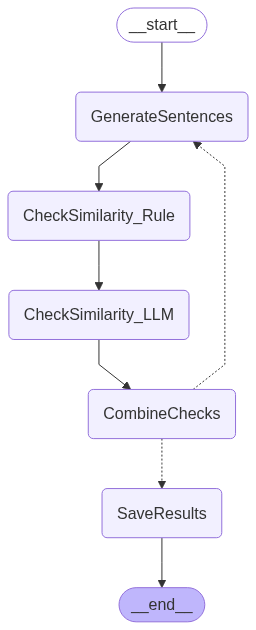

In [ ]:
def generate_sentences(state: State):

    return {}

def check_similarity_rule(state: State):

    return {}

def check_similarity_llm(state: State):

    return {}

def combine_checks(state: State):

    return {}

def save_results(state: State):

    return {}

memory = MemorySaver()
builder = StateGraph(State)

builder.add_node("GenerateSentences", generate_sentences)
builder.add_node("CheckSimilarity_Rule", check_similarity_rule)
builder.add_node("CheckSimilarity_LLM", check_similarity_llm)
builder.add_node("CombineChecks", combine_checks)
builder.add_node("SaveResults", save_results)

builder.add_edge(START, "GenerateSentences")
builder.add_edge("GenerateSentences", "CheckSimilarity_Rule")
builder.add_edge("CheckSimilarity_Rule", "CheckSimilarity_LLM")
builder.add_edge("CheckSimilarity_LLM", "CombineChecks")
builder.add_conditional_edges(
    "CombineChecks",
    lambda s: "SaveResults" if s.get("valid") else "GenerateSentences",
    {"SaveResults": "SaveResults", "GenerateSentences": "GenerateSentences"},
)
builder.add_edge("SaveResults", END)
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

If you are familiar with AI agents, then using LangGraph to build an AI Agent is highly appropriate for this task. This is because reverse translation is not just about a step that can get done in a snap, but also involves generating candidate sentences, performing rule-based similarity checks on words in those sentences, invoking large language models for semantic comparison, and combining multiple verification processes. This entire workflow aligns with the autonomous task decomposition and execution mechanisms of AI Agents. Just as illustrated in the diagram, it can break down the process into multiple steps. And by establishing checkpoint, memory, and time-travel mechanisms, we can have more confidence in the quality of the results.

# Word vector

In [ ]:
!pip install faiss-cpu
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
chinese_words = df2["Chinese"].astype(str).tolist()
english_words = df2["English"].astype(str).tolist()

zh_model = SentenceTransformer("BAAI/bge-base-zh")
en_model = SentenceTransformer("BAAI/bge-base-en")

zh_vectors = zh_model.encode(chinese_words, normalize_embeddings=True).astype("float32")
en_vectors = en_model.encode(english_words,  normalize_embeddings=True).astype("float32")

zh_index = faiss.IndexFlatIP(zh_vectors.shape[1]); zh_index.add(zh_vectors)
en_index = faiss.IndexFlatIP(en_vectors.shape[1]); en_index.add(en_vectors)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/940 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/409M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/719 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def search_similar(word, top_k,lang="zh", threshold=0.8):
    if lang == "zh":
        vec = zh_model.encode([word], normalize_embeddings=True).astype("float32")
        scores, ids = zh_index.search(vec, top_k)
        results = [
            (chinese_words[i], round(float(s), 4), df2.at[i, "Dongxiang"])
            for i, s in zip(ids[0], scores[0])
            if s >= threshold
        ]
    else:
        vec = en_model.encode([word], normalize_embeddings=True).astype("float32")
        scores, ids = en_index.search(vec, top_k)
        results = [
            (english_words[i], round(float(s), 4), df2.at[i, "Dongxiang"])
            for i, s in zip(ids[0], scores[0])
            if s >= threshold
        ]
    return results


In [ ]:
print("Chinese semantic space：", search_similar("和平", lang="zh", top_k=5))
print("English semantic space：", search_similar("peace", lang="en", top_k=5))

Chinese semantic space： [('和平', 1.0, 'hopin'), ('和平', 1.0, 'hopin'), ('变和平', 0.9302, 'hopinshi'), ('平', 0.9095, 'pin'), ('平', 0.9095, 'pin')]
English semantic space： [('Peaceful', 0.9474, 'taipin'), ('Peaceful', 0.9474, 'taipin'), ('Peaceful', 0.9474, 'hopin'), ('Peaceful', 0.9474, 'hopin'), ('Cease', 0.8816, 'sanagva')]


We use word embedding similarity to find suitable words for our translation. Specifically, for each candidate substitution, we will compute the cosine similarity between the embeddings of the original word and the proposed replacement. Only replacements with a similarity score greater than 0.8 will be accepted. This ensures that the substituted terms remain semantically appropriate while still providing enough variability for the model to learn robust patterns.

# translation

In [ ]:
df_checked

,English,Dongxiang,Chinese
0,She buys a new car every year.,She every year a new car buys.,她每年买一辆新车。
1,They buy groceries at the market on Saturdays.,They on Saturdays groceries at the market buy.,他们在星期六在市场买杂货。
2,He buys books online every month.,He every month books online buys.,他每个月在网上买书。
3,We buy fresh vegetables from the farmer's mark...,We in the morning fresh vegetables from the fa...,我们早上从农贸市场买新鲜蔬菜。
4,I buy coffee from the café after work.,I after work coffee from the café buy.,我下班后从咖啡馆买咖啡。
...,...,...,...
14994,The artist stained the canvas.,The artist the canvas stained.,艺术家染了画布。
14995,We stained the deck.,We the deck stained.,我们染了甲板。
14996,They pawned the guitar.,They the guitar pawned.,他们典当了吉他。
14997,John pawned his ring.,John his ring pawned.,约翰典当了他的戒指。


In [ ]:
import re
import itertools

STOPWORDS = {
    "a", "an", "the", "of", "to", "is", "am", "are", "was", "were", "be", "been", "being"
}
GAP = 0
TOP_K = 5
THRESHOLD = 0.8

def clean_word(cand):
    return re.sub(r"[^A-Za-z']", "", cand).strip()

def get_dongxiang_candidates(word: str):
    word_cleaned = clean_word(word)
    if not word_cleaned or word_cleaned.lower() in STOPWORDS:
        return []

    sims = search_similar(word_cleaned, lang="en", top_k=TOP_K, threshold=THRESHOLD)
    if not sims:
        return []
    top1_score = float(sims[0][1])
    result = []
    seen = set()
    for cand, score, dxg_word in sims:
        score = float(score)
        if top1_score - score == GAP:
            if dxg_word not in seen:
                result.append(dxg_word)
                seen.add(dxg_word)
    return result

def expand_dongxiang_sentence(sentence: str):
    tokens = sentence.strip().split()
    all_candidates = []
    for token in tokens:
        cands = get_dongxiang_candidates(token)
        if cands:
            all_candidates.append(cands)
    if not all_candidates:
        return []

    all_combinations = list(itertools.product(*all_candidates))
    joined_sentences = [" ".join(combo) for combo in all_combinations]
    if len(joined_sentences) > 10: # If one sentence may have different translations due to synonyms, we randomly select 10
      return random.sample(joined_sentences, 10)
    else:
      return joined_sentences


In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()

df_checked["Dongxiang_Expanded"] = df_checked["Dongxiang"].progress_apply(expand_dongxiang_sentence)
df_expanded = df_checked.explode("Dongxiang_Expanded", ignore_index=True)
df_expanded.to_csv("/content/drive/MyDrive/final_translation.csv", index=False, encoding="utf-8-sig")

  0%|          | 0/14999 [00:00<?, ?it/s]

In [ ]:
df_expanded

,English,Dongxiang,Chinese,Dongxiang_Expanded
0,She buys a new car every year.,She every year a new car buys.,她每年买一辆新车。,egven nie ni zhin shini bibi agi
1,She buys a new car every year.,She every year a new car buys.,她每年买一辆新车。,tere nie ni hon shini chezi taran jila
2,She buys a new car every year.,She every year a new car buys.,她每年买一辆新车。,hhe nie ni zhin shini bibi taran jila
3,She buys a new car every year.,She every year a new car buys.,她每年买一辆新车。,hhe nie ni hon shini chezi agi
4,She buys a new car every year.,She every year a new car buys.,她每年买一辆新车。,egven nie ni zhin shini chezi agi
...,...,...,...,...
117634,Mary pawned the bracelet.,Mary the bracelet pawned.,玛丽典当了手镯。,anei shoukonzi zuzu
117635,Mary pawned the bracelet.,Mary the bracelet pawned.,玛丽典当了手镯。,anei panzi zuzu
117636,Mary pawned the bracelet.,Mary the bracelet pawned.,玛丽典当了手镯。,ana shoukua zuzu
117637,Mary pawned the bracelet.,Mary the bracelet pawned.,玛丽典当了手镯。,ana shoukonzi zuzu
